In [1]:
from unemployment import *
from unemployment import evaluate_model, plot_predictions, display_metrics_table

In [2]:
from pygam import LinearGAM, s

In [3]:
file_path = "fredupdated.csv"
df = pd.read_csv(file_path)

# observation_date to datetime format
df['observation_date'] = pd.to_datetime(df['observation_date'])
df = df.sort_values(by='observation_date')

# Inflation Rate (Year-over-Year Percentage Change in CPI)
df['Inflation_Rate'] = (df['CPIAUCSL'].pct_change(periods=12)) * 100

predictor_cols = ['Inflation_Rate', 'GDP', 'PCE', 'FEDFUNDS', 'GS10', 'M2SL', 'GDPC1', 'CIVPART', 'PPIACO']

# > 1948 onwards 
df = df[df['observation_date'] >= '1948-01-01'].reset_index(drop=True)
df_model = df.dropna(subset= predictor_cols).copy()

/var/folders/jf/c8f7b3_x0x9c5j45htwwt28c0000gn/T/ipykernel_4502/2964240518.py:9: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['Inflation_Rate'] = (df['CPIAUCSL'].pct_change(periods=12)) * 100


# Visualization
- We visualize:
    - Quarterly unemployment rate in the US from 1948 to 2025.
    - 10 year rolling mean of the unemployment rate.
    - Unemployment vs Inflation philips curve.

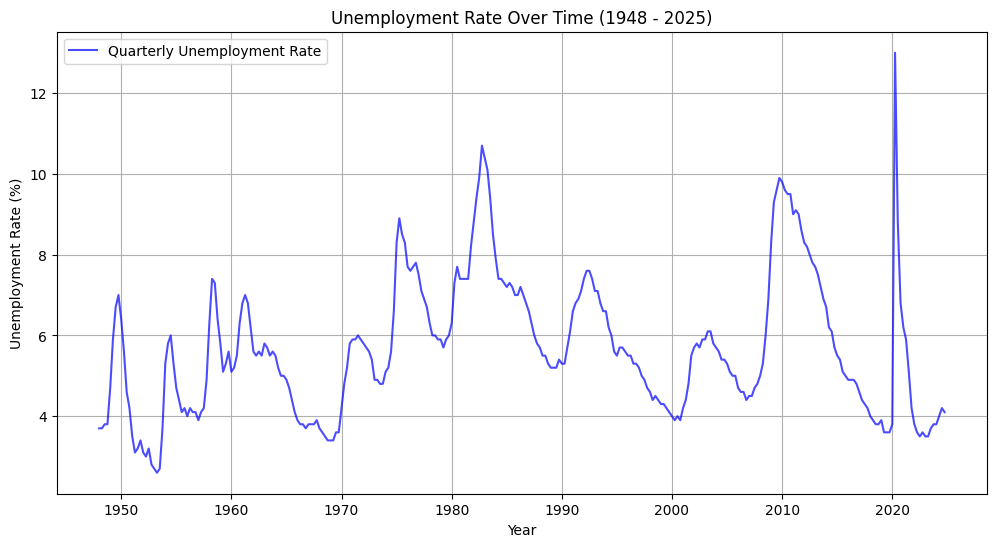

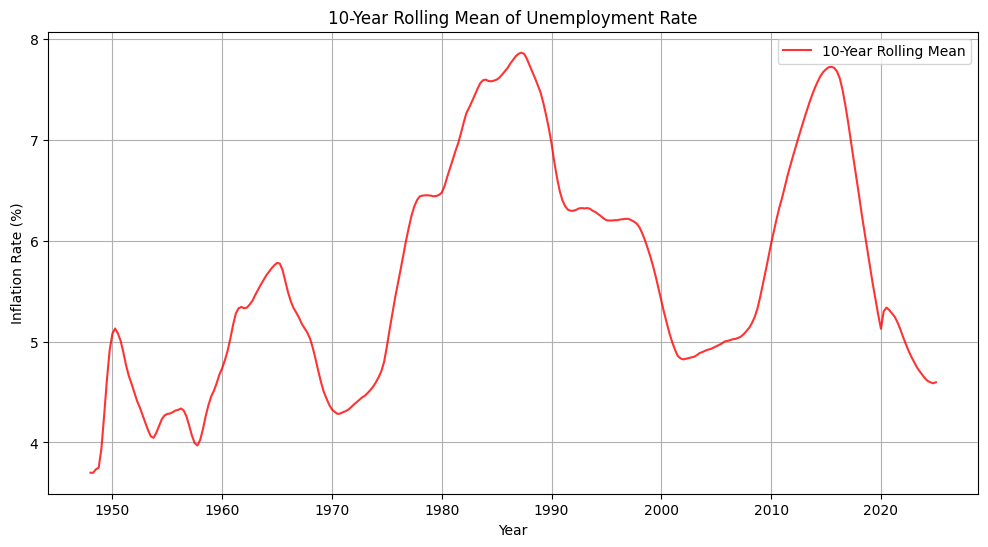

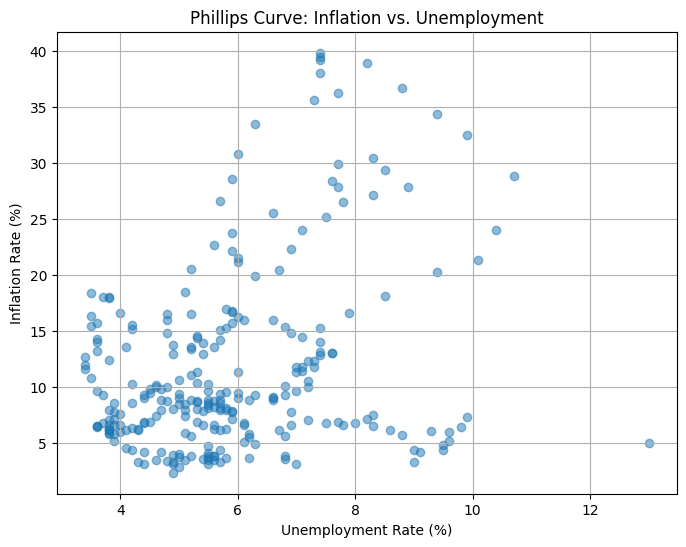

In [4]:
# Time Series Plot: Monthly Inflation Rate
plt.figure(figsize=(12, 6))
plt.plot(df['observation_date'], df['UNRATE'], label='Quarterly Unemployment Rate', color='blue', alpha=0.7)
plt.title("Unemployment Rate Over Time (1948 - 2025)")
plt.xlabel("Year")
plt.ylabel("Unemployment Rate (%)")
plt.legend()
plt.grid(True)
plt.show()

# 10-Year (120 months -> 30 quarters) Rolling Mean of Inflation Rate
df['Rolling_UNRATE'] = df['UNRATE'].rolling(window=30, min_periods=1).mean()
plt.figure(figsize=(12, 6))
plt.plot(df['observation_date'], df['Rolling_UNRATE'], label='10-Year Rolling Mean', color='red', alpha=0.8)
plt.title("10-Year Rolling Mean of Unemployment Rate")
plt.xlabel("Year")
plt.ylabel("Inflation Rate (%)")
plt.legend()
plt.grid(True)
plt.show()

# Scatter Plot: Inflation vs. Unemployment (Phillips Curve)
plt.figure(figsize=(8, 6))
plt.scatter(df_model['UNRATE'], df_model['Inflation_Rate'], alpha=0.5)
plt.xlabel("Unemployment Rate (%)")
plt.ylabel("Inflation Rate (%)")
plt.title("Phillips Curve: Inflation vs. Unemployment")
plt.grid(True)
plt.show()

In [5]:
# Target = unemployment rate
# Predictor = inflation rate
X = df_model[predictor_cols].values
y = df_model['UNRATE'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [6]:
unemployment_data = df_model['UNRATE']
dates = df_model['observation_date']

In [7]:
# FOR ARIMA
train_data = pd.Series(y_train)
test_data = pd.Series(y_test)

In [8]:
train_size = len(train_data)
train_dates = dates[:train_size]
test_dates = dates[train_size:]

In [9]:
# 4: ARIMA with Standard Parameters
# Fit ARIMA model (p=1, d=1, q=1) - standard parameters for economic data
model = ARIMA(train_data, order=(1, 1, 1))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  211
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -23.099
Date:                Sun, 09 Mar 2025   AIC                             52.197
Time:                        22:53:43   BIC                             62.238
Sample:                             0   HQIC                            56.256
                                - 211                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5754      0.064      9.010      0.000       0.450       0.701
ma.L1          0.0853      0.092      0.928      0.353      -0.095       0.265
sigma2         0.0728      0.006     13.184      0.000       0.062       0.084
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                38.25
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               0.53   Skew:                             0.51
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [10]:
train_predictions = model_fit.predict(start=0, end=len(train_data)-1)
test_predictions = model_fit.forecast(steps=len(test_data))

train_metrics = evaluate_model(train_data, train_predictions, "Training")
test_metrics = evaluate_model(test_data, test_predictions, "Test")

In [11]:
display_metrics_table(train_metrics, test_metrics, model_name="ARIMA(1,1,1)")


Model Evaluation: ARIMA(1,1,1)
------------------------------------------------------------
Metric          Training Set         Test Set            
------------------------------------------------------------
MSE             0.2328                15.9286
RMSE            0.4825                3.9911
MAE             0.2247                3.6667
R^2             0.9071                -3.3749
Accuracy        0.9198                0.2499
Accuracy (%)    91.98%              24.99%
------------------------------------------------------------


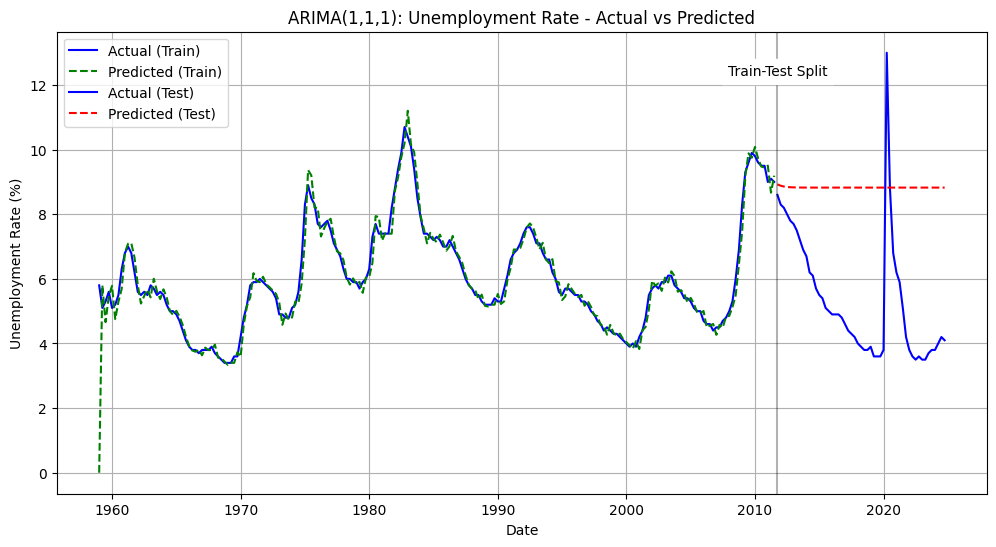

In [12]:
plot_predictions(
    train_data, train_predictions, 
    test_data, test_predictions,
    train_dates, test_dates, 
    model_name="ARIMA(1,1,1)"
)


Model Evaluation: Random Forest
------------------------------------------------------------
Metric          Training Set         Test Set            
------------------------------------------------------------
MSE             0.0238                9.2143
RMSE            0.1543                3.0355
MAE             0.1099                2.8530
R^2             0.9905                -1.5308
Accuracy        0.9744                0.4295
Accuracy (%)    97.44%              42.95%
------------------------------------------------------------


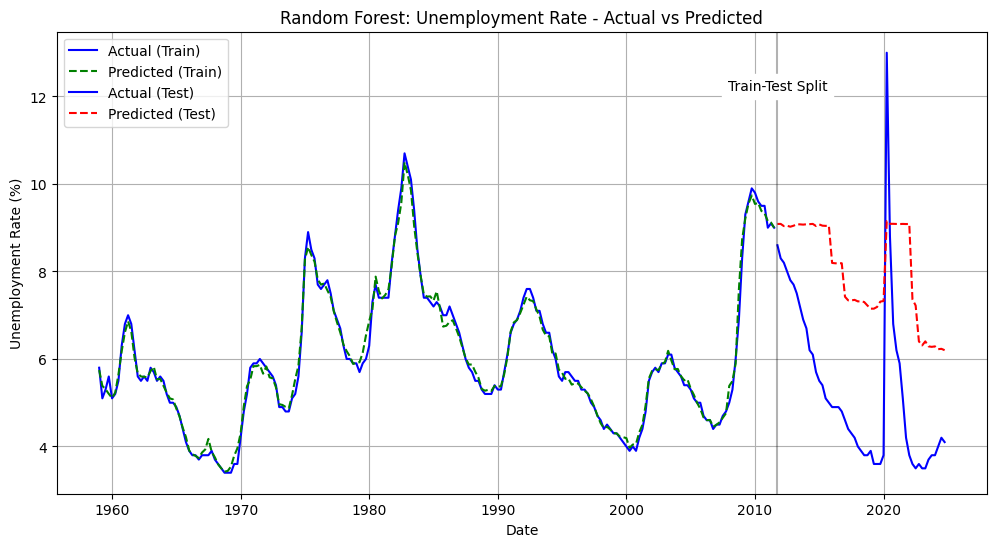

In [13]:
# 5: Random Forest Regressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
train_predictions = rf_model.predict(X_train)
test_predictions = rf_model.predict(X_test)

# Evaluate model
train_metrics = evaluate_model(y_train, train_predictions, "Training")
test_metrics = evaluate_model(y_test, test_predictions, "Test")

# Display metrics
display_metrics_table(train_metrics, test_metrics, model_name="Random Forest")

# Plot the results
plot_predictions(
    y_train, train_predictions, 
    y_test, test_predictions,
    train_dates, test_dates, 
    model_name="Random Forest"
)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best k value: 29
Training KNN Regression model with k=29...

Model Evaluation: KNN (k=29)
------------------------------------------------------------
Metric          Training Set         Test Set            
------------------------------------------------------------
MSE             1.1226                5.4908
RMSE            1.0595                2.3432
MAE             0.8068                2.0634
R^2             0.5520                -0.5081
Accuracy        0.8239                0.5596
Accuracy (%)    82.39%              55.96%
------------------------------------------------------------


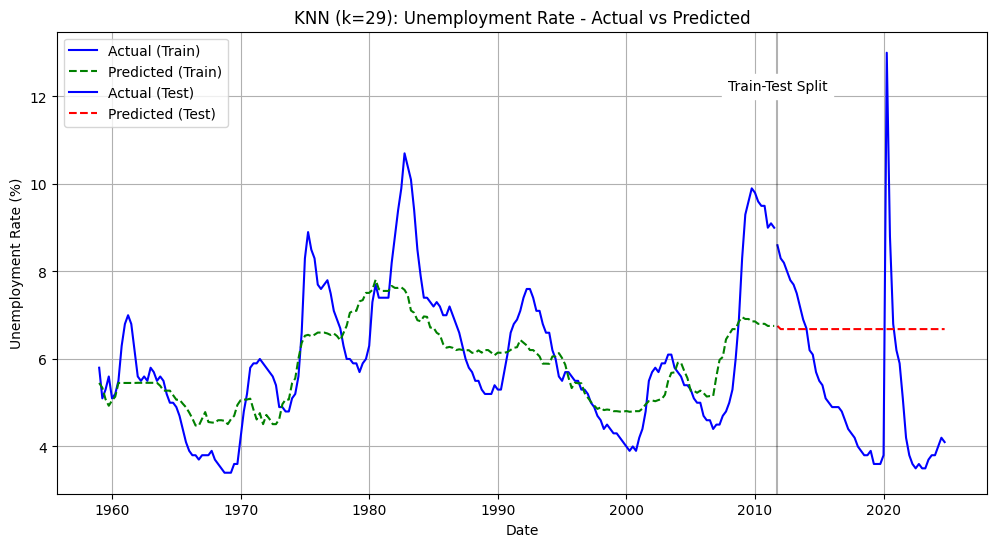

In [14]:
# 6: k-Nearest Neighbors Regressor
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# optimal k using cross-validation
param_grid = {'n_neighbors': range(1, 30, 2)}
grid_search = GridSearchCV(
    KNeighborsRegressor(), 
    param_grid, 
    cv=5, 
    scoring='neg_mean_squared_error',
    verbose=1
)
grid_search.fit(X_train_scaled, y_train)

best_k = grid_search.best_params_['n_neighbors']
print(f"Best k value: {best_k}")

print(f"Training KNN Regression model with k={best_k}...")
knn_model = KNeighborsRegressor(n_neighbors=best_k)
knn_model.fit(X_train_scaled, y_train)

train_predictions = knn_model.predict(X_train_scaled)
test_predictions = knn_model.predict(X_test_scaled)

train_metrics = evaluate_model(y_train, train_predictions, "Training")
test_metrics = evaluate_model(y_test, test_predictions, "Test")

display_metrics_table(train_metrics, test_metrics, model_name=f"KNN (k={best_k})")

plot_predictions(
    y_train, train_predictions, 
    y_test, test_predictions,
    train_dates, test_dates, 
    model_name=f"KNN (k={best_k})"
)

In [ ]:
# 7: GAM with Spline Terms 
# have to use scikit cause pygam has issues with numpy's new release
feature_models = []
feature_predictions_train = []
feature_predictions_test = []

for i, feature_name in enumerate(predictor_cols):
    spline = make_pipeline(
        SplineTransformer(n_knots=5, degree=3),
        LinearRegression()
    )
    
    spline.fit(X_train_scaled[:, i:i+1], y_train)
    
    pred_train = spline.predict(X_train_scaled[:, i:i+1])
    pred_test = spline.predict(X_test_scaled[:, i:i+1])
    
    feature_models.append(spline)
    feature_predictions_train.append(pred_train)
    feature_predictions_test.append(pred_test)


Model Evaluation: GAM (scikit-learn)
------------------------------------------------------------
Metric          Training Set         Test Set            
------------------------------------------------------------
MSE             1.1587                13.3723
RMSE            1.0764                3.6568
MAE             0.8481                3.3824
R^2             0.5375                -2.6728
Accuracy        0.8211                0.3127
Accuracy (%)    82.11%              31.27%
------------------------------------------------------------


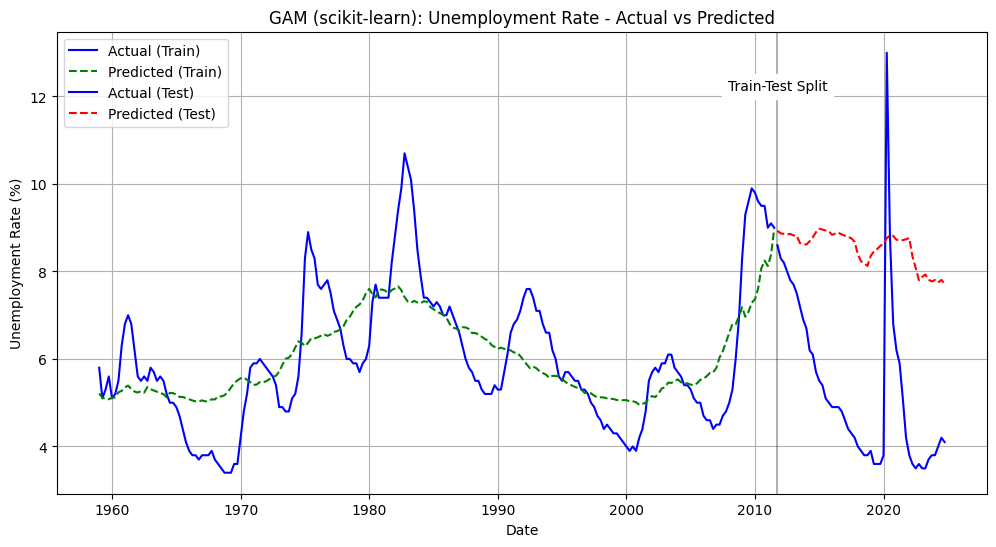

In [ ]:
train_predictions = np.mean(feature_predictions_train, axis=0)
test_predictions = np.mean(feature_predictions_test, axis=0)

train_metrics = evaluate_model(y_train, train_predictions, "Training")
test_metrics = evaluate_model(y_test, test_predictions, "Test")

display_metrics_table(train_metrics, test_metrics, model_name="GAM (scikit-learn)")

plot_predictions(
    y_train, train_predictions, 
    y_test, test_predictions,
    train_dates, test_dates, 
    model_name="GAM (scikit-learn)"
)